In [38]:
#!pip install  pmdarima==1.8.4;

In [39]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf

plt.style.use('seaborn-white')
# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

# sARIMA

Goal: Forecast the value of $y_{t} $ based on past values $y_{t-1}, y_{t-2}, \dots$.

$$
y_{t} = F(y_{t-1}, y_{t-2}, \dots) + \epsilon_t
$$


## Integrated I(d)

> To remove the trend (mean stationary), it is differenced $d$ times before model estimation.

$$
\Delta y_t = y_t - y_{t-1}
$$


## Autoregressive AR(p)

> The current value of the time-series can be modeled as a weighted sum of past values of the forecast variable.

$$
F_{AR}(y_{t-1}, y_{t-2}, \dots) = \alpha_1y_{t-1} + \alpha_2y_{t-2} + \dots
$$

## Moving Average MA(q)

> The current value of the time-series can be modeled as a weighted sum of past values of the forecast error.

⚠️ This has not much to do with the moving/rolling average operation of pandas

$$
F_{MA}(y_{t-1}, y_{t-2}, \dots) = \beta_1\epsilon_{t-1} + \beta_2\epsilon_{t-2} + \dots
$$



## Seasonal s (P, D, Q)

> To remove seasonality the ARIMA model is applied to seasonal differences and lags.

# Forecasts applied to real data

#### In the long run, ARIMA models "just" forecast the trend and seasonal part of the time series!

In [42]:
y = sns.load_dataset('flights')
y['month'] = y['month'].cat.codes + 1 #converts months to numbers
y['day'] = 1 #use first of each month
y.index = pd.to_datetime(y[['year', 'month', 'day']]) #creates datetime index
y = y['passengers']
y.head(3)

FileNotFoundError: [Errno 2] File data_remainder_alex.csv does not exist: 'data_remainder_alex.csv'

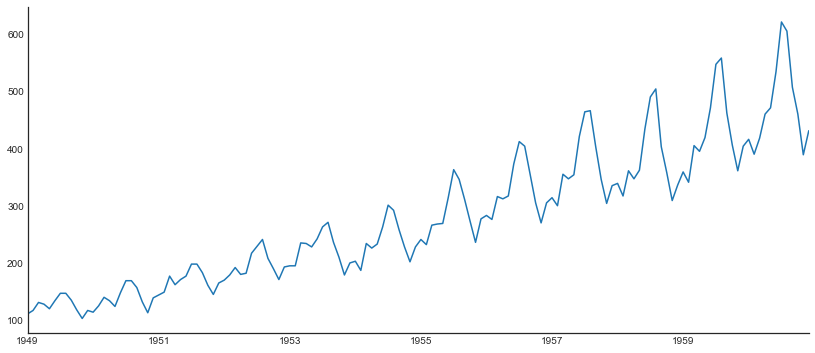

In [41]:
y.plot(
    # figsize=(12, 6),
    # title='Flights',
    # ylabel='Passengers',
    # xlabel='Time'
)
sns.despine()

## How can we make the time series stationary?

- remove trend: first difference (d=1)
- remove seasonality: seasonal difference (D=1, m=12)
- remove changes in variance: box-cox/ log transformation

Task is to decrease mean value and standard deviation

In [ ]:
 # with logarithmic we play with the variance
 # with dif we play with the seasonality

2.237762237762238

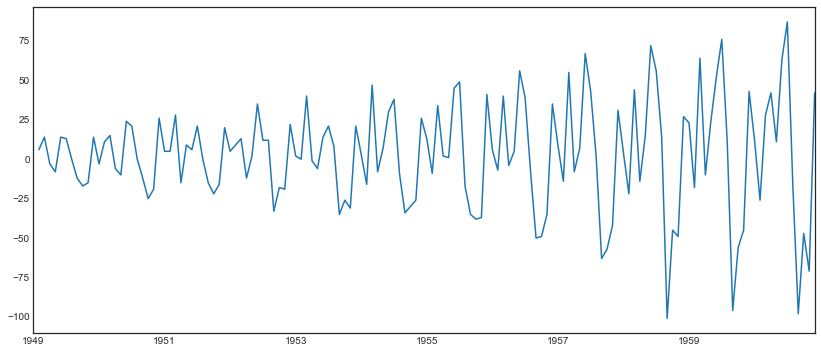

In [32]:
y.diff(1).plot()
y.diff(1).mean()
y.diff(1).std()

0.0002908798783924881
0.04584829264762389


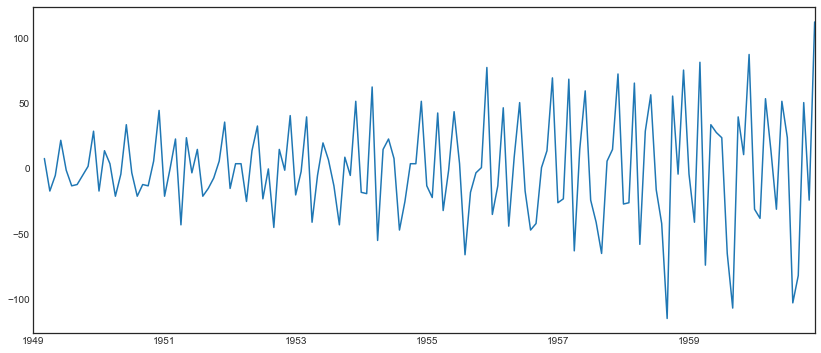

In [37]:
y.log(y).diff(1).diff(12).plot()  # with logarithmic we play with the variance
print(np.log(y).diff(1).diff(12).mean())
print(np.log(y).diff(1).diff(12).std())

<AxesSubplot:>

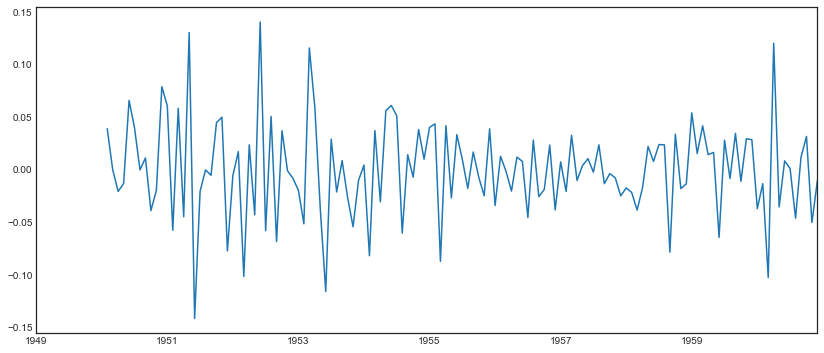

In [29]:
np.log(y).diff(1).diff(12).plot()

## AutoARIMA

In [22]:
arima = pm.AutoARIMA(
    m=12,              # seasonality cycle
    d=1,               # apply differences
    D=1,               # apply seasonal difference
    maxiter=10000,
    seasonal=True
)

arima.fit(y)
arima.summary()


# BEst score is the one with the least AIC between different models, autoregression or Autoarima etc..
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Thu, 28 Apr 2022   AIC                           1017.847
Time:                                     10:49:38   BIC                           1029.348
Sample:                                          0   HQIC                          1022.520
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      0.091      2.343      0.019       0.035       0.394
ma.L1         -0.9819      0.038    -25.601      0.000      -1.057      -0.907
sigma2       129.3132     14.556      8.884      0.000     100.783     157.843
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

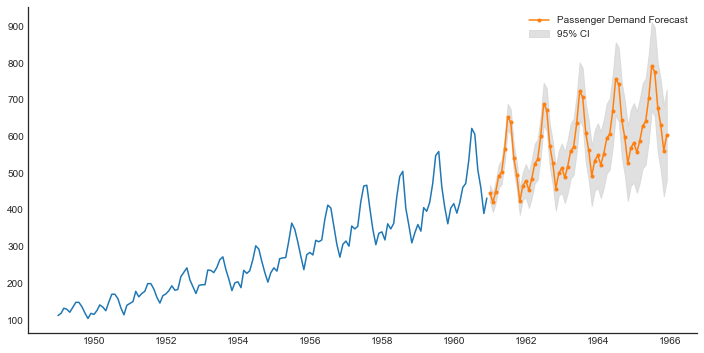

In [7]:
# forecast for the next 5 years with uncertainty area
y_forecast, ci = arima.predict(n_periods=12*5, return_conf_int=True) #n_periods=12*5 number of extra rows to be pradected

# create some date values for the forecast horizon
index_vals = pd.date_range('1961-01-01', '1965-12-01', freq='MS')


#plt.figure(figsize=(12,6))
plt.plot(y.index.values, y.values)
plt.fill_between(index_vals.values, ci[:,0], ci[:, 1], alpha=0.7, color='lightgrey', label='95% CI')
plt.plot(index_vals.values, y_forecast, label='Passenger Demand Forecast', marker='.')
sns.despine()
plt.legend()

## Residual analysis

/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


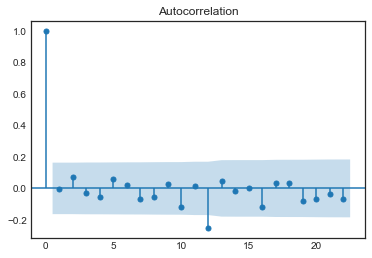

In [8]:
# is the error truly random?
y_fit = arima.predict_in_sample()
y_fit = pd.Series(y_fit, index=y.index)
p = plot_acf(y-y_fit)

## Pros and Cons

- it's a good baseline and good starter
- offers confidence intervals, uncertainty quantification
- good performance


- needs univariate numeric time series data
- restrictive model function
- unable to model complex seasonality (solution: use additional dummy matrix as feature matrix)
